# Aspect-Based Sentiment Analysis (ABSA) using Deep Learning and Clustering

This notebook implements an Aspect-Based Sentiment Analysis system using a combination of deep learning for sentiment classification and clustering for aspect extraction. We'll be using a dataset of hotel reviews to demonstrate this approach.

## Step 1: Import Required Libraries

In [1]:
!pip install -q hdbscan
!pip install -q sentence-transformers bertopic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, GPT2Model, BertTokenizer, GPT2Tokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from tqdm import tqdm

import copy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from gensim.corpora import Dictionary
# from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

from wordcloud import WordCloud
import os
import pickle

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set random seed for reproducibility
np.random.seed(42)

2024-08-25 10:25:08.176484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 10:25:08.176608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 10:25:08.338608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Data Loading and Exploring

We'll start by loading our hotel review dataset and explore top stat of the data.

- Import Libraries:
We start by importing the necessary Python libraries for data manipulation (pandas), numerical operations (numpy), data visualization (matplotlib and seaborn), and machine learning tasks (sklearn).
Load the Dataset:
We use pandas to read the CSV file containing hotel reviews data. The dataset is stored in the variable 'data'.
- Display First Few Rows:
The head() function is used to display the first 3 rows of the dataset. This gives us a quick overview of the data structure and content.
- Dataset Information:
The info() function provides a summary of the dataset, including column names, non-null counts, and data types. This helps us understand the overall structure of the dataset and identify any missing values or data type issues.

#### Load the dataset

In [2]:
file_path = "/kaggle/input/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv"
data = pd.read_csv(file_path)

#### Display the first few rows of the dataset

In [3]:
data.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


#### Display information about the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

#### Show descriptive statistics

- The dataset contains 515,738 reviews (count).
- The average score given to hotels is approximately 8.40 out of 10, indicating generally positive reviews.
- The average number of reviews per hotel is about 2,743, but with a high standard deviation (2,317), suggesting wide variation in hotel popularity.
- On average, reviews contain about 18 negative words and 18 positive words.
- The minimum number of reviews for a hotel is 43, while the maximum is 16,670.


Insights:

- Hotels in the dataset are generally well-rated, with an average score of 8.40.
- There's a significant disparity in the number of reviews per hotel, which could indicate varying levels of popularity or differences in how long hotels have been listed.
- The similar averages for positive and negative word counts suggest a balance in review sentiment, though this needs further investigation.

In [5]:
data.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.395077,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.637856,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


## Step 3: Data Cleaning

Let's do some data cleaning...

#### check for duplicated data points ( rows in df dataframe )

In [6]:
data.duplicated().sum()

526

#### Let's drop duplicate rows values

In [7]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

#### Check for missing values
- Let's check that is any null values into my dataframe df or not

In [8]:
data.isnull().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64

- `Here, we can see that there are NaN values in the columns 'lat' and 'lag'. For this project, we do not want to use these features, so we are just dropping them.`

In [9]:
data.drop(['lat', 'lng'], axis = 1, inplace = True)
data.isnull().sum()

Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
dtype: int64

## Step 4: EDA

Let's do exploratory data analysis...

#### Top 10 Hotels in Terms of Average Score

In [10]:
data.groupby(['Hotel_Name'])[['Average_Score']].mean().sort_values('Average_Score', ascending=False).head(10)

,Average_Score
Hotel_Name,
Ritz Paris,9.8
41,9.6
Hotel Casa Camper,9.6
H10 Casa Mimosa 4 Sup,9.6
Hotel The Serras,9.6
H tel de La Tamise Esprit de France,9.6
Haymarket Hotel,9.6
Hotel The Peninsula Paris,9.5
Le Narcisse Blanc Spa,9.5


#### Top 10 Most Frequently Mentioned or Reviewed Hotels

In [11]:
data['Hotel_Name'].value_counts()[:10].reset_index()

,Hotel_Name,count
0,Britannia International Hotel Canary Wharf,4789
1,Strand Palace Hotel,4256
2,Park Plaza Westminster Bridge London,4169
3,Copthorne Tara Hotel London Kensington,3577
4,DoubleTree by Hilton Hotel London Tower of London,3212
5,Grand Royale London Hyde Park,2958
6,Holiday Inn London Kensington,2768
7,Hilton London Metropole,2628
8,Millennium Gloucester Hotel London,2565
9,Intercontinental London The O2,2551


- **Note**: `Even though the 'Britannia International Hotel Canary Wharf' is frequently mentioned or reviewed in the dataset, the 'Ritz Paris' tends to receive higher average review scores, indicating greater customer satisfaction.`

In [12]:
data.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review'],
      dtype='object')

#### The top five nationality in rating are United Kingdom, United States of America, Australia,Ireland and United Arab Emirates

In [13]:
data['Reviewer_Nationality'].value_counts()[:5].reset_index()

,Reviewer_Nationality,count
0,United Kingdom,245110
1,United States of America,35349
2,Australia,21648
3,Ireland,14814
4,United Arab Emirates,10229


#### The least five nationality in rating are Cape Verde, Northern Mariana Islands, Tuvalu, Guinea and Palau

In [14]:
data['Reviewer_Nationality'].value_counts()[-5:].reset_index()

,Reviewer_Nationality,count
0,Vatican City,1
1,Anguilla,1
2,Tuvalu,1
3,Guinea,1
4,Palau,1


#### Create a correlation heatmap

- Strong positive correlation (0.82) between 'Additional_Number_of_Scoring' and 'Total_Number_of_Reviews', indicating that hotels with more reviews tend to have more scores.
- Moderate positive correlation (0.36) between 'Average_Score' and 'Reviewer_Score', suggesting some consistency between individual reviewer scores and overall average scores.
- Weak negative correlation (-0.38) between 'Review_Total_Negative_Word_Counts' and 'Reviewer_Score', implying that reviews with more negative words tend to have slightly lower scores.
- Weak positive correlation (0.22) between 'Review_Total_Positive_Word_Counts' and 'Reviewer_Score', suggesting that reviews with more positive words tend to have slightly higher scores.
- Interestingly, 'lat' (latitude) shows a moderate positive correlation (0.34) with 'Additional_Number_of_Scoring', which might indicate regional differences in review behaviors.

Insights:

- The number of reviews and scores are closely related, which is expected.
- The weak correlations between word counts and scores suggest that simple word count might not be the most effective method for sentiment analysis; we may need more sophisticated text processing techniques.
- The geographical correlation (latitude) with scoring behavior could be an interesting avenue for further investigation, possibly revealing cultural differences in review patterns.

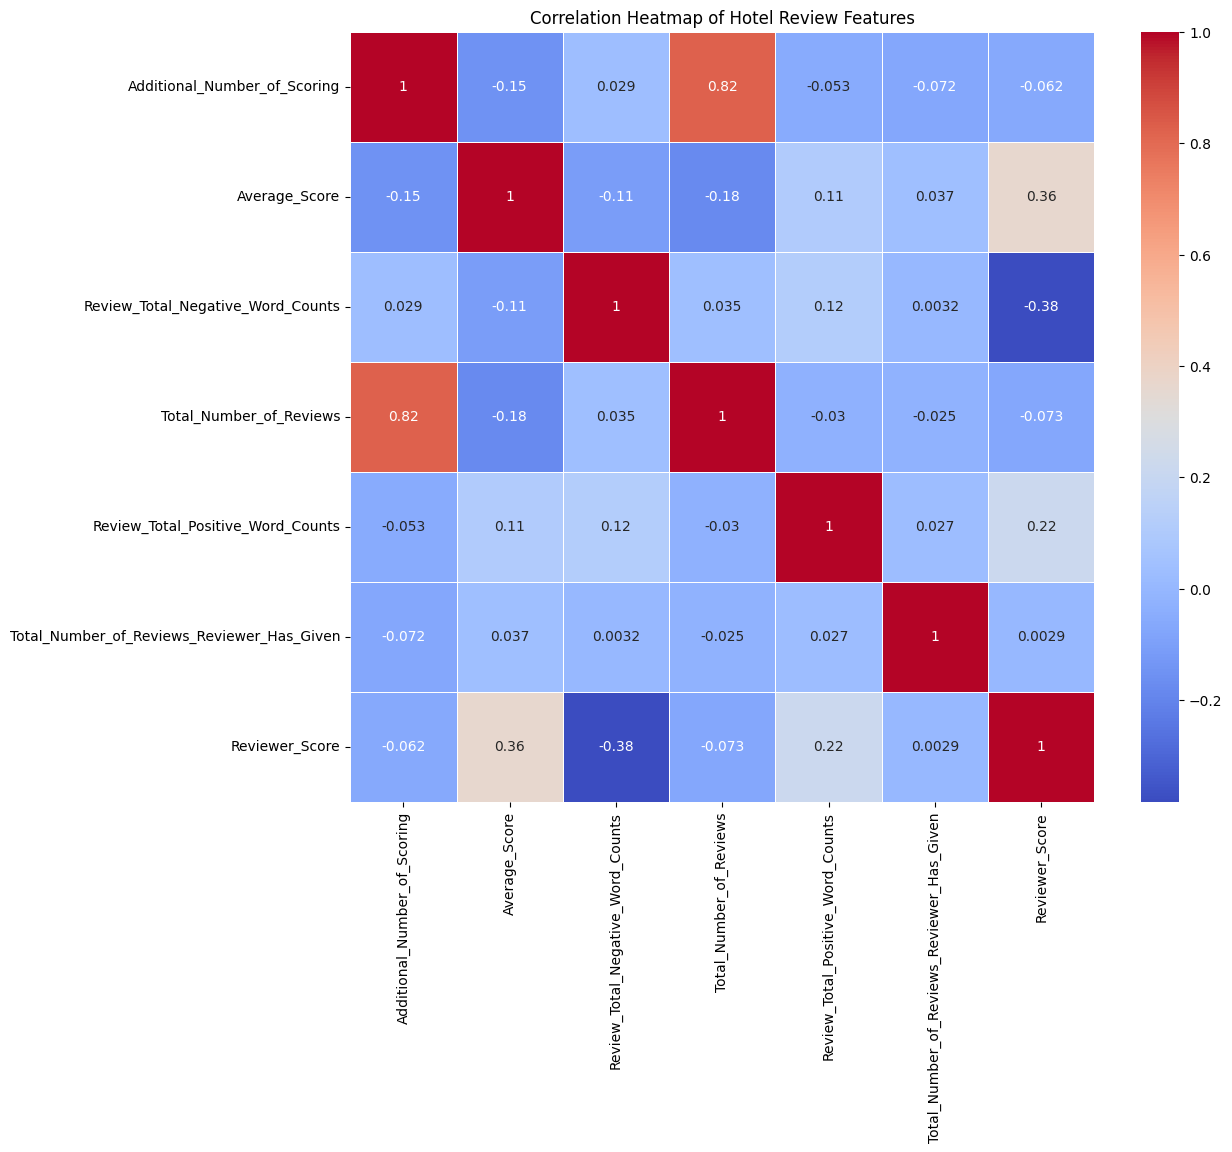

In [15]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
numeric_data = data[numeric_columns]

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Hotel Review Features')
plt.show()

#### Date feature engineering

In [16]:
data['Review_Date'] = pd.to_datetime(data['Review_Date'])
data['years'] = data['Review_Date'].dt.year
data['months'] = data['Review_Date'].dt.month

# Display updated dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Hotel_Address                               515212 non-null  object        
 1   Additional_Number_of_Scoring                515212 non-null  int64         
 2   Review_Date                                 515212 non-null  datetime64[ns]
 3   Average_Score                               515212 non-null  float64       
 4   Hotel_Name                                  515212 non-null  object        
 5   Reviewer_Nationality                        515212 non-null  object        
 6   Negative_Review                             515212 non-null  object        
 7   Review_Total_Negative_Word_Counts           515212 non-null  int64         
 8   Total_Number_of_Reviews                     515212 non-null  int64         
 9 

#### Visualize trends

- Total reviews by year

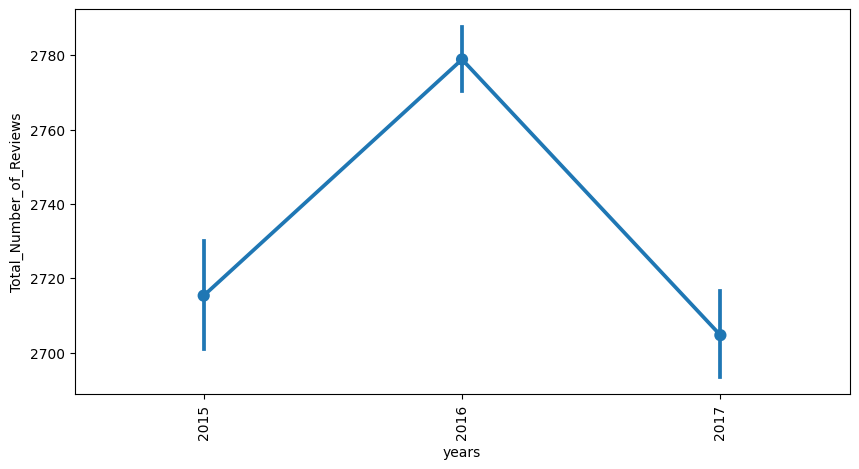

In [17]:
plt.figure(figsize = (10, 5))
sns.pointplot(data=data, x='years', y='Total_Number_of_Reviews')
plt.xticks(rotation=90)
plt.show()

#### Monthly trends
- The reviewer scores exhibit a peak around the second month, followed by a decline until the seventh month, and then an upward trend towards the end of the year. This fluctuation might be influenced by seasonal variations, with higher satisfaction possibly during off-peak travel seasons and lower satisfaction during peak travel periods due to overcrowding or overbooking.

- There is a gradual decline in the number of reviews from the beginning of the year until the seventh month, after which there is a slight increase. This pattern might indicate that fewer people travel during certain months, leading to fewer reviews, while travel and review activity picks up towards the end of the year, possibly due to holidays and vacations.

- The average scores remain relatively stable with minor fluctuations throughout the year. There is a noticeable dip in the seventh month, which could correspond with the peak travel season, where the influx of tourists might strain hotel services, leading to slightly lower average scores.

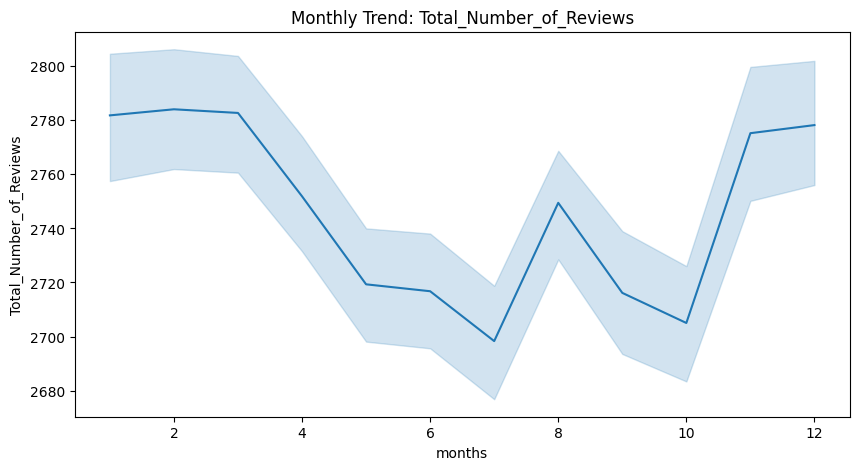

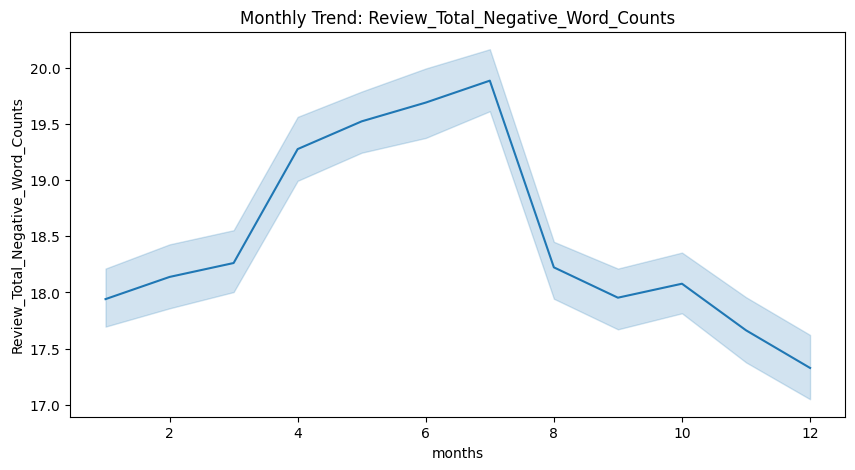

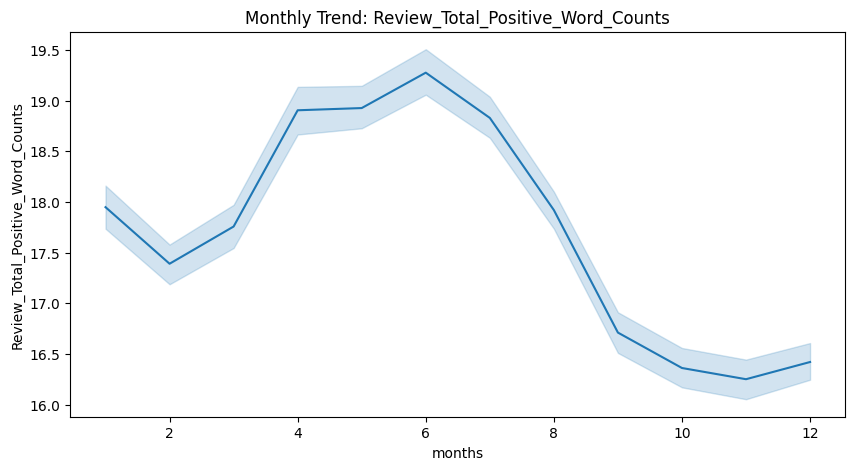

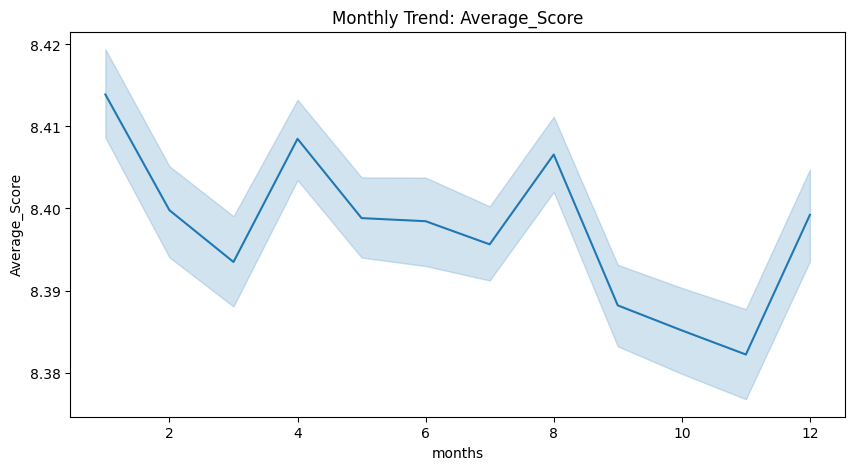

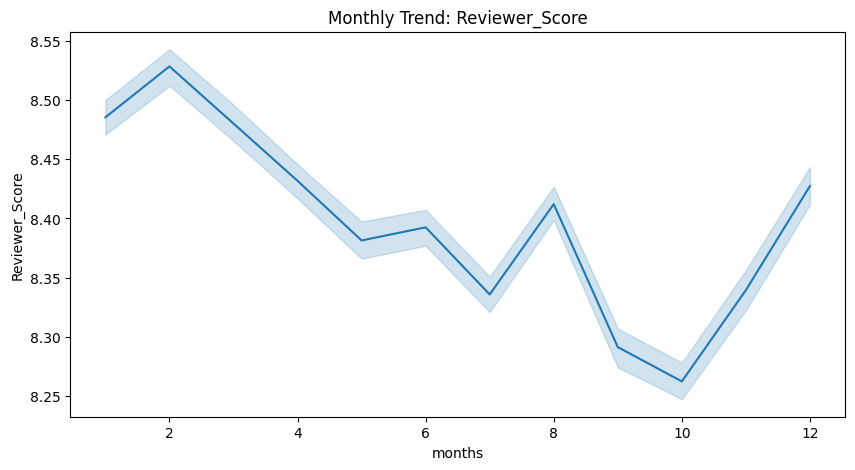

In [18]:
features = ['Total_Number_of_Reviews', 'Review_Total_Negative_Word_Counts', 
            'Review_Total_Positive_Word_Counts', 'Average_Score', 'Reviewer_Score']

for feature in features:
    plt.figure(figsize = (10, 5))
    sns.lineplot(data=data, x='months', y=feature)
    plt.title(f'Monthly Trend: {feature}')
    plt.show()

#### Distribution of Average Scores
- The distribution is positively skewed, with the majority of average scores concentrated between 7.5 and 9.0. This suggests that most reviewers tend to give higher scores to hotels, indicating general satisfaction with the services provided.

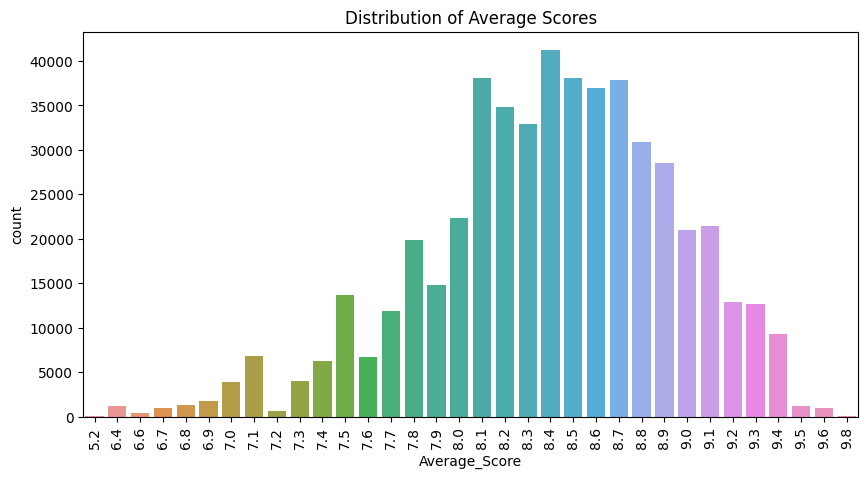

In [19]:
plt.figure(figsize = (10, 5))
sns.countplot(data=data, x='Average_Score')
plt.xticks(rotation=90)
plt.title('Distribution of Average Scores')
plt.show()

## Step 5: Data preprocessing & feature engineering

#### Cleaning Review Texts
`First, we will clean the 'Positive_Review' and 'Negative_Review' columns by removing placeholder text such as 'No Positive' and 'No Negative'.`
- Replacing 'No Positive' with an empty string in the 'Positive_Review' column

- Replacing 'No Negative' with an empty string in the 'Negative_Review' column

In [20]:
data.loc[:, 'Positive_Review'] = data.Positive_Review.apply(lambda x: x.replace('No Positive', ''))

data.loc[:, 'Negative_Review'] = data.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

#### Combining Review Texts
- Combining 'Positive_Review' and 'Negative_Review' into a single column 'Total_Review'

In [21]:
data["Total_Review"] = data["Negative_Review"] + data["Positive_Review"]

#### Categorizing Reviews by Score
`We will categorize the reviews based on the 'Reviewer_Score'. Reviews with a score less than 7 will be labeled as 'Bad_review', while others will be labeled as 'Good_review'.`
- Creating a new column 'review_type' based on the 'Reviewer_Score'

In [22]:
data["review_type"] = data["Reviewer_Score"].apply(
    lambda x: "Bad_review" if x < 7 else "Good_review")

#### Selecting Relevant Columns

In [23]:
# Selecting only the 'Total_Review' and 'review_type' columns for further analysis
df_reviews = data[["Total_Review", "review_type"]]

#### Displaying the first few rows of the processed data

In [24]:
df_reviews.head()

,Total_Review,review_type
0,I am so angry that i made this post available...,Bad_review
1,No real complaints the hotel was great great ...,Good_review
2,Rooms are nice but for elderly a bit difficul...,Good_review
3,My room was dirty and I was afraid to walk ba...,Bad_review
4,You When I booked with your company on line y...,Bad_review


### Balancing & dealing with imbalanced dataset classification

#### Existing data label look like ( Imbalanced )

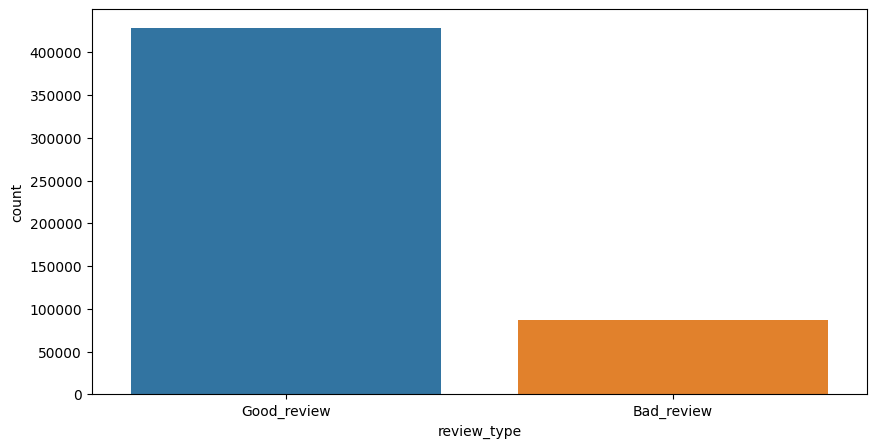

In [25]:
plt.figure(figsize = (10, 5))
sns.countplot(
  x='review_type',
  data=df_reviews,
  order=df_reviews.review_type.value_counts().index
);

#### Separating Good and Bad Reviews
- In this step, we separate the reviews into two categories: good reviews and bad reviews. This allows us to analyze and process each category independently.

In [26]:
good_reviews = df_reviews[df_reviews.review_type == "Good_review"]
bad_reviews = df_reviews[df_reviews.review_type == "Bad_review"]

#### Balancing the Dataset
- Sample from good reviews to match the number of bad reviews.
- Combine the sampled good reviews with all bad reviews.
- Reset the index of the new balanced dataset.
- Display the shape of the resampled dataset to confirm the balance.

`This process ensures an equal representation of both review types in our analysis.`

In [27]:
df_review_resampled = pd.concat([
    good_reviews.sample(n=len(bad_reviews), random_state=42),
    bad_reviews,
], axis = 0).sample(frac = 1, random_state = 42).reset_index(drop = True)

df_review_resampled.shape

(173434, 2)

#### Visualizing the Balanced Dataset

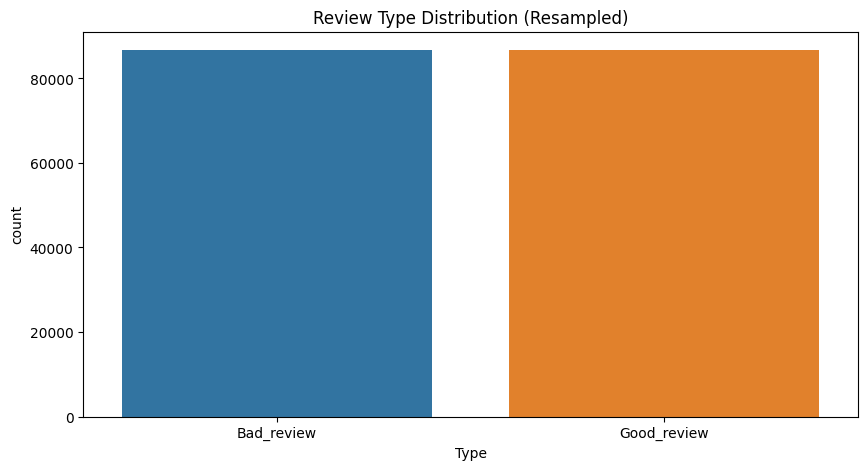

In [28]:
plt.figure(figsize = (10, 5))
sns.countplot(
  x='review_type',
  data=df_review_resampled,
  order=df_review_resampled.review_type.value_counts().index
)
plt.xlabel("Type")
plt.title("Review Type Distribution (Resampled)")
plt.show()

In [29]:
# df_review_resampled = df_review_resampled[:5000]

#### Data Encoding
- Label Encoding for Review Types

- The result is stored in encoded_review, which now contains:

- `0: Representing one review type (e.g., "Bad_review")`
- `1: Representing the other review type (e.g., "Good_review")`

In [30]:
encoder = LabelEncoder()
encoded_review = encoder.fit_transform(df_review_resampled.review_type.values)
encoded_review.shape

(173434,)

#### Split Data into Train and Test Sets
- This step splits our data into training and testing sets, with 75% for training and 25% for testing.

In [31]:
reviews = df_review_resampled.Total_Review.tolist()
labels = encoded_review.tolist()

In [32]:
len(reviews)

173434

### `This methodology document outlines a novel approach to ABSA using BERTopic, a state-of-the-art topic modeling technique, combined with coherence optimization and `


```bash
[Raw Text Data] → [Text Preprocessing] → [Aspect Extraction (BERTopic)] 
                                                ↓
[Sentiment Scoring] ← [Aspect-Sentiment Mapping] ← [Coherence Optimization]
                                                ↓
                                      [Aspect Visualization]
```

### Text Preprocessing
The text preprocessing module is crucial for cleaning and standardizing the input data. It involves the following steps:
- Lowercasing: Convert all text to lowercase to ensure consistency.
- Noise Removal: Eliminate URLs, email addresses, and numerical data using regular expressions.
- Tokenization: Split the text into individual words or tokens.
- Stopword Removal: Remove common words that don't contribute significantly to the meaning.
- Short Token Removal: Eliminate tokens with two or fewer characters.

This module improves the quality of input for the subsequent aspect extraction process.

In [33]:
def preprocess_text(text):
    # Get NLTK's stopwords
    stop_words = set(stopwords.words('english'))

    # Add custom stopwords (your existing list)
    custom_stops = {
        "this", "that", "these", "those", "here", "there",
        "where", "when", "how", "why", "what", "who", "whom",
        "which", "whose", "whoever", "whatever", "wherever",
        "however", "thing", "things", "something", "anything",
        "nothing", "everything", "somebody", "anybody", "nobody",
        "everybody", "someone", "anyone", "everyone", "none",
        "other", "another", "others", "each", "such", "rather",
        "either", "neither", "whether", "whichever", "whenever",
        "always", "never", "sometimes", "often", "usually",
        "rarely", "seldom", "occasionally", "frequently",
        "generally", "typically", "commonly", "normally",
        "regularly", "irregularly", "periodically", "constantly",
        "continually", "continuously", "intermittently",
        "sporadically", "just", "really", "very", "quite",
        "literally", "actually", "basically", "virtually",
        "get", "got", "getting", "go", "going", "went", "gone",
        "come", "coming", "came", "say", "saying", "said", "says",
        "tell", "telling", "told", "tells", "know", "knowing",
        "knew", "knows", "think", "thinking", "thought", "thinks",
        "want", "wanting", "wanted", "wants", "lot", "bit", "stuff",
        "kind", "sort", "type", "way", "example", "instance",
        "case", "point", "matter", "good", "bad", "okay", "fine",
        "great", "awesome", "terrible", "horrible", "nice",
        "excellent", "poor", "wonderful", "amazing", "awful",
        "fantastic", "better", "best", "worse", "worst", "least", "most"
    }  # Your existing custom stopwords
    stop_words.update(custom_stops)

    # Preprocess function
    def preprocess(text):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs, email addresses, and numbers
        text = re.sub(r'http\S+|www\S+|https\S+|\S*@\S*\s?|\d+', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Filter tokens
        tokens = [token for token in tokens 
                  if token not in stop_words
                  and len(token) > 2  # Remove tokens with 2 or fewer characters
                  and not token.isspace()]
        
        return " ".join(tokens)

    # Apply preprocessing
    return preprocess(text)

### Aspect Extraction using BERTopic

BERTopic is employed for aspect extraction due to its ability to create coherent and interpretable topics. The process involves:
- Embedding Generation: Use a pre-trained BERT model (e.g., "all-MiniLM-L6-v2") to generate embeddings for each preprocessed document.
- Dimensionality Reduction: Apply UMAP (Uniform Manifold Approximation and Projection) to reduce the high-dimensional embeddings to a lower-dimensional space while preserving the global structure of the data.
- Clustering: Utilize HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to cluster the reduced embeddings, identifying dense regions in the data space that correspond to potential aspects.
- Topic Creation: For each cluster, extract the most representative terms to form topics or aspects.

### Theoretical Foundations
- **BERTopic**
    - BERTopic is grounded in transformer-based language models, specifically BERT (Bidirectional Encoder Representations from Transformers). It leverages the contextual embeddings produced by BERT to capture semantic relationships in the text data.
- **UMAP**
    - UMAP is based on Riemannian geometry and algebraic topology. It preserves both local and global structure in the data, making it well-suited for maintaining semantic relationships in the reduced dimensional space.
- **HDBSCAN**
    - HDBSCAN is an extension of DBSCAN that performs density-based clustering. It excels at finding clusters of varying densities and shapes, which is particularly useful for identifying coherent aspects in the embedded space.
- **Coherence Measures**
    - The CV coherence measure is based on a sliding window approach and normalized pointwise mutual information (NPMI). It provides a quantitative measure of the semantic interpretability of the extracted aspects.

### Coherence Score Calculation

### What is a Coherence Score?
A coherence score is a way to measure how good or meaningful a set of topics is in topic modeling.

#### How Does It Work?
1. **Word Groups**: When we do topic modeling, we get groups of words that are supposed to represent different topics or themes in our text.
1. **Checking Connections**: The coherence score looks at how often these words appear together in the same documents. Words that frequently show up together are more likely to be related and form a coherent topic.
1. **Measuring "Togetherness"**: It calculates how strong these connections are between the words in each topic.
1. **Scoring**: The stronger and more frequent these connections, the higher the coherence score.

#### What Does a Higher Score Mean?
A higher coherence score generally means:

1. **More Meaningful Topics**: The words in each topic are more likely to make sense together.
1. **Better Clustering**: The model has done a good job of grouping related words and separating unrelated ones.
1. **Easier to Interpret**: Humans can more easily understand and label these topics.

In [34]:
def calculate_coherence_score(texts, topics, dictionary):
    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()

### Coherence Optimization ( Finding Optimal Aspects )
To determine the optimal number of aspects, we implement a coherence optimization process:
- opic Range Iteration: Iterate through a range of potential topic numbers (e.g., 2 to 20).
- odel Generation: For each number of topics, generate a BERTopic model and reduce the topics to the specified number.
- oherence Calculation: Calculate the coherence score for each model using the CV (Coherence Value) metric, which is based on a sliding window, one-set segmentation of the top words, and an indirect cosine measure.
- ptimal Selection: Choose the number of topics that yields the highest coherence score, representing the most interpretable and semantically meaningful set of aspects.

#### 1. Silhouette Score:
- **What it Measures**: The silhouette score measures the consistency within clusters (how similar data points are within the same cluster) compared to data points in other clusters.
- **Why it's Useful**: It helps you assess the quality of the clustering structure, particularly in terms of how well-separated the clusters are. A higher silhouette score indicates that clusters are well-formed and distinct from each other.

#### 2. Coherence Score:
- **What it Measures**: In the context of topic modeling (like BERTopic), the coherence score evaluates how interpretable and meaningful the topics (or clusters) are. For BERTopic, which combines aspects of topic modeling with clustering, the coherence score can give insight into how well the topics (clusters) represent coherent themes.
- Why it's Useful: This score provides a way to measure the semantic quality of the clusters, making sure that each cluster represents a distinct and meaningful theme or topic.

#### Combining Silhouette Score and Coherence Score:
- **Balanced Evaluation**: By using both metrics, you can achieve a more balanced evaluation. The silhouette score focuses on the structural quality of the clusters, while the coherence score ensures that the clusters are semantically meaningful.
- **Finding the Optimal Number of Clusters**: You can experiment with different numbers of clusters (or topics) and track both metrics. The optimal number of clusters is likely to be the one where you observe a good balance between a high silhouette score and a high coherence score.

In [35]:
def show_scores_table(scores_table_df):
    print("\nMain coherence & silhouette table.\n")
    print(scores_table_df)
    print("\n\n")
    # Create a 1x2 grid of subplots for the coherence & Silhouette graph
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting Coherence Score
    axes[0].plot(scores_table_df['num_topics'], scores_table_df['coherence_score'], marker='o', color='b')
    axes[0].set_title('Coherence Score vs. Number of Topics')
    axes[0].set_xlabel('Number of Topics')
    axes[0].set_ylabel('Coherence Score')
    axes[0].grid(True)

    # Plotting Silhouette Score
    axes[1].plot(scores_table_df['num_topics'], scores_table_df['silhouette_score'], marker='o', color='g')
    axes[1].set_title('Silhouette Score vs. Number of Topics')
    axes[1].set_xlabel('Number of Topics')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)
    fig.savefig("coherence_silhouette_score.png")

    # Adjust layout
    plt.tight_layout()

    # Plot the average of coherence and silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(scores_table_df['num_topics'], scores_table_df['avg_of_coherence_and_silhouette'], marker='o', color='r')
    plt.title('Average of Coherence and Silhouette Score vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average of Coherence and Silhouette Score')
    plt.grid(True)
    plt.savefig("avg_of_coherence_and_silhouette_score.png")

    # Show both figures
    plt.show()

In [36]:
def find_optimal_aspects_bertopic(texts, min_topics=4, max_topics=20):
    preprocessed_texts = [preprocess_text(text) for text in texts]
    
    # Create a dictionary and corpus for coherence score calculation
    texts = [text.split() for text in preprocessed_texts]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    best_model = None
    best_aspect_labels = None
    best_coherence = -1
    best_silhouette = -1
    best_avg_coherence_silhouette = -1
    best_n_topics = 0
    
    scores_table = {
        "coherence_score": [],
        "silhouette_score": [],
        "avg_of_coherence_and_silhouette": [],
        "num_topics": [],
        "withoutNoiseNumTopics": []
    }
    
    for n_topics in range(min_topics, max_topics + 1):
        print(f"\n\nEvaluating model with {n_topics} topics...")
        
        # Initialize and fit BERTopic model
        # sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    
        # umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
        umap_model = PCA(n_components=5)
        
        # hdbscan_model = HDBSCAN(min_cluster_size=15,  metric='euclidean', cluster_selection_method='eom', prediction_data=True)
        cluster_model = KMeans(n_clusters=n_topics)
        
        # Create BERTopic model
        topic_model = BERTopic(
            umap_model=umap_model,
            embedding_model="allenai-specter", # #sentence_model,
            hdbscan_model=cluster_model,# hdbscan_model
            calculate_probabilities=True,
            verbose=True
        )
        
        # Fit the model
        aspect_labels, _ = topic_model.fit_transform(preprocessed_texts)
     
        # Extract the embeddings
        embeddings = topic_model._extract_embeddings(preprocessed_texts) # This depends on BERTopic version
        
        # Calculate Silhouette Score using embeddings and labels
        silhouette_avg = silhouette_score(embeddings, aspect_labels)
        
        # Calculate coherence score
        temp_topics = [ topic for topic in topic_model.get_topics().keys() if topic != -1 and len(topic_model.get_topic(topic)) > 0 ]
        topic_words = [[word for word, _ in topic_model.get_topic(topic)] for topic in temp_topics ]
        coherence_score = calculate_coherence_score(texts, topic_words, dictionary)
        
        withoutNoiseNumTopics = len(temp_topics)
        
        scores_table['coherence_score'].append(coherence_score)
        scores_table['silhouette_score'].append(silhouette_avg)
        scores_table['avg_of_coherence_and_silhouette'].append((coherence_score + silhouette_avg)/2)
        scores_table['num_topics'].append(n_topics)
        scores_table['withoutNoiseNumTopics'].append(withoutNoiseNumTopics)
        
        print(f"Coherence Score for {n_topics} topics: {coherence_score}")
        print(f"Silhouette Score for {n_topics} topics: {silhouette_avg}")
        print(f"Avg of Silhouette and Coherence Score for {n_topics} topics: {silhouette_avg}")
        
        if (coherence_score + silhouette_avg)/2 > best_avg_coherence_silhouette:
            best_avg_coherence_silhouette = (coherence_score + silhouette_avg)/2
            best_coherence = coherence_score
            best_silhouette = silhouette_avg
            best_model = topic_model
            best_aspect_labels = aspect_labels
            best_n_topics = withoutNoiseNumTopics
        
        
    # Get topic names and keywords
    topic_names = []
    topic_keywords = best_model.get_topic_info()
    temp_topics = list(best_model.get_topics().keys())
        
    for topic in temp_topics:
        try:
            keywords = topic_keywords.loc[topic_keywords['Topic'] == topic, 'Name'].values

            if topic != -1 and len(keywords) > 0:
                topic_names.append(keywords[0])
            else:
                print(f"Topic_{topic}: it's not considered as desired topics.")
        except IndexError:
            print(f"Topic_{topic}: it encountered an IndexError...")
            
            
    scores_table_df = pd.DataFrame(scores_table)
    scores_table_df.to_csv("coherence_silhouette_score.csv", index = False)
    
    show_scores_table(scores_table_df)
    
    return best_model, best_aspect_labels, best_n_topics, best_avg_coherence_silhouette, best_coherence, best_silhouette, topic_names

### Aspect Visualization
To aid in the interpretation and presentation of the extracted aspects, we implement two visualization techniques:
- Interactive Topic Visualization: Utilize BERTopic's built-in visualization tools to create an interactive HTML representation of the topics, showing their relationships and distributions.
- Word Cloud Generation: For each aspect, generate a word cloud that visually represents the most significant terms, with font size corresponding to term importance within the aspect.

These visualizations provide intuitive ways to understand and communicate the extracted aspects.

In [37]:
def visualize_aspects(topic_model, save_path="aspect_visualization.html"):
    try:
        # Get all topics
        all_topics = sorted(list(topic_model.get_topics().keys()))
        
        # Filter out the -1 topic (if present) as it represents unclustered documents
        topics_to_visualize = [topic for topic in all_topics if topic != -1 and len(topic_model.get_topic(topic)) > 0]
        
        # Visualize topics
        fig = topic_model.visualize_topics(topics=topics_to_visualize)
        
        # Save the visualization
        fig.write_html(save_path)
        print(f"Topic visualization saved to {save_path}")
    except Exception as e:
        print(f"Error in visualizing topics: {str(e)}")
        print("Falling back to text-based topic representation.")
        
        # Text-based representation as a fallback
        topic_info = topic_model.get_topic_info()
        with open(save_path.replace('.html', '.txt'), 'w') as f:
            for _, row in topic_info.iterrows():
                if row['Topic'] != -1:  # Exclude the -1 topic
                    f.write(f"Topic {row['Topic']}: {row['Name']}\n")
        print(f"Text-based topic representation saved to {save_path.replace('.html', '.txt')}")

def generate_wordclouds(topic_model, num_topics, save_path="wordclouds"):
    os.makedirs(save_path, exist_ok=True)
    all_topics = sorted(list(topic_model.get_topics().keys()))
    topics_to_visualize = [topic for topic in all_topics if topic != -1 and len(topic_model.get_topic(topic)) > 0]
    
    for topic in topics_to_visualize:
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic_model.get_topic(topic)))
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Aspect {topic}")
            plt.savefig(f"{save_path}/aspect_{topic}_wordcloud.png")
            plt.close()
        except Exception as e:
            print(f"Error generating wordcloud for topic {topic}: {str(e)}")

### Running the Analysis
`Now, let's run our analysis:`

`This will find the optimal number of aspects, print the aspect names, visualize the aspects, and generate word clouds.`


#### After running the analysis, you'll have:

The optimal number of aspects for your dataset.
- A list of aspect names, which give you an idea of the main themes in your reviews.
- An interactive HTML visualization of the topics, which you can explore to understand the relationships between different aspects.
- Word clouds for each aspect, which visually represent the most important words in each aspect.

These results can help you understand the main themes and topics present in your review dataset, which is crucial for aspect-based sentiment analysis.

In [38]:
# best_model, best_aspect_labels, best_n_topics, best_coherence, topic_names

2024-08-25 10:28:45,025 - BERTopic - Embedding - Transforming documents to embeddings.




Evaluating model with 4 topics...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 10:34:23,759 - BERTopic - Embedding - Completed ✓
2024-08-25 10:34:23,760 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 10:34:26,945 - BERTopic - Dimensionality - Completed ✓
2024-08-25 10:34:26,952 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 10:34:28,066 - BERTopic - Cluster - Completed ✓
2024-08-25 10:34:28,105 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 10:34:31,240 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 4 topics: 0.49075254929877277
Silhouette Score for 4 topics: 0.06203579530119896
Avg of Silhouette and Coherence Score for 4 topics: 0.06203579530119896


Evaluating model with 5 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 11:01:37,144 - BERTopic - Embedding - Completed ✓
2024-08-25 11:01:37,145 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 11:01:40,364 - BERTopic - Dimensionality - Completed ✓
2024-08-25 11:01:40,369 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 11:01:41,783 - BERTopic - Cluster - Completed ✓
2024-08-25 11:01:41,825 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 11:01:44,952 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 5 topics: 0.4965692325641117
Silhouette Score for 5 topics: 0.06221441924571991
Avg of Silhouette and Coherence Score for 5 topics: 0.06221441924571991


Evaluating model with 6 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 11:28:51,093 - BERTopic - Embedding - Completed ✓
2024-08-25 11:28:51,094 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 11:28:54,435 - BERTopic - Dimensionality - Completed ✓
2024-08-25 11:28:54,442 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 11:28:57,695 - BERTopic - Cluster - Completed ✓
2024-08-25 11:28:57,735 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 11:29:00,946 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 6 topics: 0.4917767862385691
Silhouette Score for 6 topics: 0.05667999014258385
Avg of Silhouette and Coherence Score for 6 topics: 0.05667999014258385


Evaluating model with 7 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 11:56:15,022 - BERTopic - Embedding - Completed ✓
2024-08-25 11:56:15,023 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 11:56:18,235 - BERTopic - Dimensionality - Completed ✓
2024-08-25 11:56:18,241 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 11:56:21,394 - BERTopic - Cluster - Completed ✓
2024-08-25 11:56:21,434 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 11:56:24,563 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 7 topics: 0.5050305761852706
Silhouette Score for 7 topics: 0.05003514885902405
Avg of Silhouette and Coherence Score for 7 topics: 0.05003514885902405


Evaluating model with 8 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 12:23:50,050 - BERTopic - Embedding - Completed ✓
2024-08-25 12:23:50,051 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 12:23:53,332 - BERTopic - Dimensionality - Completed ✓
2024-08-25 12:23:53,338 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 12:23:55,947 - BERTopic - Cluster - Completed ✓
2024-08-25 12:23:55,986 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 12:23:59,166 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 8 topics: 0.49910114358207747
Silhouette Score for 8 topics: 0.05015206336975098
Avg of Silhouette and Coherence Score for 8 topics: 0.05015206336975098


Evaluating model with 9 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 12:51:05,400 - BERTopic - Embedding - Completed ✓
2024-08-25 12:51:05,401 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 12:51:08,530 - BERTopic - Dimensionality - Completed ✓
2024-08-25 12:51:08,536 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 12:51:12,564 - BERTopic - Cluster - Completed ✓
2024-08-25 12:51:12,602 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 12:51:15,633 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 9 topics: 0.49672462633968156
Silhouette Score for 9 topics: 0.041919827461242676
Avg of Silhouette and Coherence Score for 9 topics: 0.041919827461242676


Evaluating model with 10 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 13:18:18,641 - BERTopic - Embedding - Completed ✓
2024-08-25 13:18:18,642 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 13:18:21,887 - BERTopic - Dimensionality - Completed ✓
2024-08-25 13:18:21,893 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 13:18:25,699 - BERTopic - Cluster - Completed ✓
2024-08-25 13:18:25,737 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 13:18:28,879 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 10 topics: 0.4949475261000675
Silhouette Score for 10 topics: 0.03729750216007233
Avg of Silhouette and Coherence Score for 10 topics: 0.03729750216007233


Evaluating model with 11 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 13:45:31,400 - BERTopic - Embedding - Completed ✓
2024-08-25 13:45:31,401 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 13:45:34,648 - BERTopic - Dimensionality - Completed ✓
2024-08-25 13:45:34,654 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 13:45:38,777 - BERTopic - Cluster - Completed ✓
2024-08-25 13:45:38,816 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 13:45:41,892 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 11 topics: 0.49860788438671017
Silhouette Score for 11 topics: 0.03498883545398712
Avg of Silhouette and Coherence Score for 11 topics: 0.03498883545398712


Evaluating model with 12 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 14:12:42,859 - BERTopic - Embedding - Completed ✓
2024-08-25 14:12:42,861 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 14:12:46,108 - BERTopic - Dimensionality - Completed ✓
2024-08-25 14:12:46,114 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 14:12:50,497 - BERTopic - Cluster - Completed ✓
2024-08-25 14:12:50,535 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 14:12:53,921 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 12 topics: 0.4987035109943931
Silhouette Score for 12 topics: 0.03134087473154068
Avg of Silhouette and Coherence Score for 12 topics: 0.03134087473154068


Evaluating model with 13 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 14:39:52,227 - BERTopic - Embedding - Completed ✓
2024-08-25 14:39:52,228 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 14:39:55,411 - BERTopic - Dimensionality - Completed ✓
2024-08-25 14:39:55,417 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 14:40:00,511 - BERTopic - Cluster - Completed ✓
2024-08-25 14:40:00,548 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 14:40:03,879 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 13 topics: 0.5062115560196042
Silhouette Score for 13 topics: 0.032027143985033035
Avg of Silhouette and Coherence Score for 13 topics: 0.032027143985033035


Evaluating model with 14 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 15:06:53,736 - BERTopic - Embedding - Completed ✓
2024-08-25 15:06:53,737 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 15:06:56,985 - BERTopic - Dimensionality - Completed ✓
2024-08-25 15:06:56,991 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 15:07:02,021 - BERTopic - Cluster - Completed ✓
2024-08-25 15:07:02,058 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 15:07:05,300 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 14 topics: 0.5043819529118178
Silhouette Score for 14 topics: 0.03162425756454468
Avg of Silhouette and Coherence Score for 14 topics: 0.03162425756454468


Evaluating model with 15 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 15:34:13,304 - BERTopic - Embedding - Completed ✓
2024-08-25 15:34:13,305 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 15:34:16,542 - BERTopic - Dimensionality - Completed ✓
2024-08-25 15:34:16,549 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 15:34:21,743 - BERTopic - Cluster - Completed ✓
2024-08-25 15:34:21,781 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 15:34:25,006 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 15 topics: 0.5111999380907848
Silhouette Score for 15 topics: 0.029748255386948586
Avg of Silhouette and Coherence Score for 15 topics: 0.029748255386948586


Evaluating model with 16 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 16:01:22,034 - BERTopic - Embedding - Completed ✓
2024-08-25 16:01:22,036 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 16:01:25,281 - BERTopic - Dimensionality - Completed ✓
2024-08-25 16:01:25,286 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 16:01:31,100 - BERTopic - Cluster - Completed ✓
2024-08-25 16:01:31,137 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 16:01:34,397 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 16 topics: 0.5139229795635376
Silhouette Score for 16 topics: 0.02906578592956066
Avg of Silhouette and Coherence Score for 16 topics: 0.02906578592956066


Evaluating model with 17 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 16:28:41,038 - BERTopic - Embedding - Completed ✓
2024-08-25 16:28:41,039 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 16:28:44,298 - BERTopic - Dimensionality - Completed ✓
2024-08-25 16:28:44,304 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 16:28:50,953 - BERTopic - Cluster - Completed ✓
2024-08-25 16:28:50,990 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 16:28:54,357 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 17 topics: 0.5206577858939767
Silhouette Score for 17 topics: 0.028369911015033722
Avg of Silhouette and Coherence Score for 17 topics: 0.028369911015033722


Evaluating model with 18 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 16:56:00,679 - BERTopic - Embedding - Completed ✓
2024-08-25 16:56:00,681 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 16:56:03,953 - BERTopic - Dimensionality - Completed ✓
2024-08-25 16:56:03,960 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 16:56:10,239 - BERTopic - Cluster - Completed ✓
2024-08-25 16:56:10,276 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 16:56:13,502 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 18 topics: 0.5206581625123087
Silhouette Score for 18 topics: 0.0289644505828619
Avg of Silhouette and Coherence Score for 18 topics: 0.0289644505828619


Evaluating model with 19 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 17:23:23,911 - BERTopic - Embedding - Completed ✓
2024-08-25 17:23:23,913 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 17:23:27,110 - BERTopic - Dimensionality - Completed ✓
2024-08-25 17:23:27,116 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 17:23:34,534 - BERTopic - Cluster - Completed ✓
2024-08-25 17:23:34,571 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 17:23:37,647 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 19 topics: 0.5258271866483905
Silhouette Score for 19 topics: 0.02957412786781788
Avg of Silhouette and Coherence Score for 19 topics: 0.02957412786781788


Evaluating model with 20 topics...


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

2024-08-25 17:50:46,336 - BERTopic - Embedding - Completed ✓
2024-08-25 17:50:46,338 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-25 17:50:49,497 - BERTopic - Dimensionality - Completed ✓
2024-08-25 17:50:49,502 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-25 17:50:56,121 - BERTopic - Cluster - Completed ✓
2024-08-25 17:50:56,158 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-25 17:50:59,318 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/5420 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 20 topics: 0.5174360587116423
Silhouette Score for 20 topics: 0.029296835884451866
Avg of Silhouette and Coherence Score for 20 topics: 0.029296835884451866

Main coherence & silhouette table.

    coherence_score  silhouette_score  avg_of_coherence_and_silhouette  \
0          0.490753          0.062036                         0.276394   
1          0.496569          0.062214                         0.279392   
2          0.491777          0.056680                         0.274228   
3          0.505031          0.050035                         0.277533   
4          0.499101          0.050152                         0.274627   
5          0.496725          0.041920                         0.269322   
6          0.494948          0.037298                         0.266123   
7          0.498608          0.034989                         0.266798   
8          0.498704          0.031341                         0.265022   
9          0.506212          0.032027         

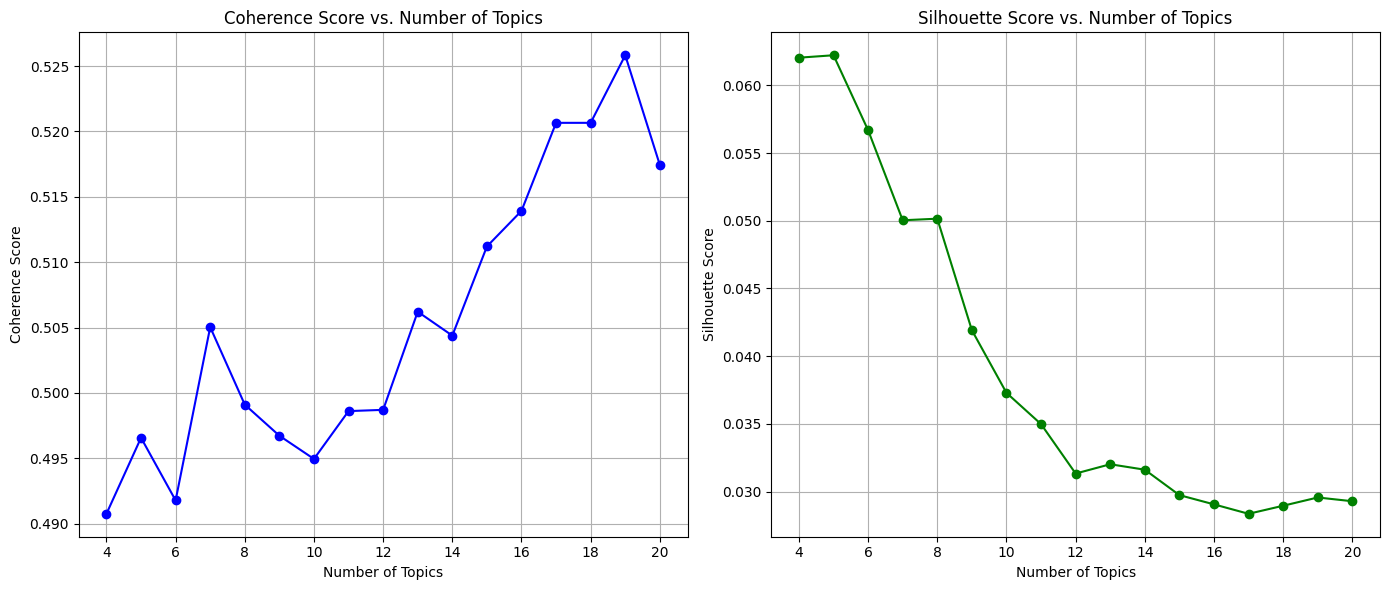

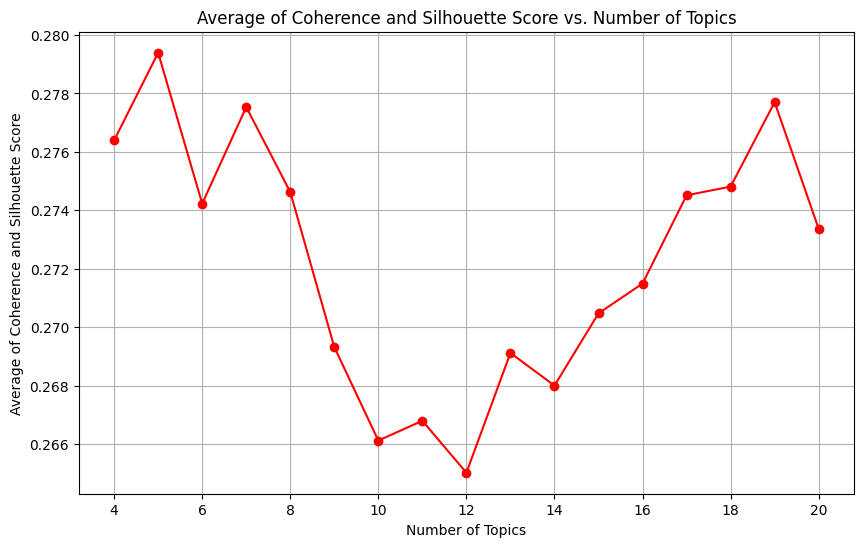

Optimal number of aspects/topics: 5
Best Avg of Silhouette and Coherence Score: 0.2793918259049158
Best Coherence Score: 0.4965692325641117
Best Coherence Score: 0.06221441924571991


Aspect names:
Aspect 0: 0_room_hotel_bed_bathroom
Aspect 1: 1_room_hotel_staff_breakfast
Aspect 2: 2_location_hotel_room_staff
Aspect 3: 3_staff_room_hotel_location
Aspect 4: 4_breakfast_room_staff_hotel



Topic visualization saved to aspect_visualization.html


In [39]:
# Find optimal number of aspects and get aspect labels using BERTopic
# optimal_num_aspects, aspect_labels, topic_names, topic_model = find_optimal_aspects_bertopic(reviews)
# best_model, best_aspect_labels, best_n_topics, best_coherence, topic_names = find_optimal_aspects_bertopic(reviews)
best_model, best_aspect_labels, best_n_topics, best_avg_coherence_silhouette, best_coherence, best_silhouette, topic_names = find_optimal_aspects_bertopic(reviews)
print(f'''Optimal number of aspects/topics: {best_n_topics}
Best Avg of Silhouette and Coherence Score: {best_avg_coherence_silhouette}
Best Coherence Score: {best_coherence}
Best Coherence Score: {best_silhouette}\n\n''')

print("Aspect names:")
for i, name in enumerate(topic_names):
    print(f"Aspect {i}: {name}")
    
print("\n\n")
# Visualize aspects
visualize_aspects(best_model)

generate_wordclouds(best_model, best_n_topics)

In [40]:
# best_model.get_topics()
# best_model.get_topic_info(1)
fig = best_model.visualize_barchart(top_n_topics = best_n_topics)
fig.write_html("topWordScores.html")
fig

In [41]:
fig = best_model.visualize_heatmap()
fig.write_html("aspectSimilarityMatrix.html")
fig

In [42]:
fig = best_model.visualize_hierarchy()
fig.write_html("hierarchicalClustering.html")
fig

In [43]:
fig = best_model.visualize_term_rank()
fig.write_html("termScoreDeclinePerTopic.html")
fig

`Save the topic information generated by the BERTopic model to a CSV file named "aspect_table.csv"`
`Display the topic information generated by the BERTopic model in the output/console.`

In [44]:
best_model.get_topic_info().to_csv("aspect_table.csv", index = False)
best_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,47587,0_room_hotel_bed_bathroom,"[room, hotel, bed, bathroom, staff, location, ...",[friendly helpful staff comfortable clean room...
1,1,38934,1_room_hotel_staff_breakfast,"[room, hotel, staff, breakfast, friendly, help...",[booked hotel three nights new year dec januar...
2,2,29957,2_location_hotel_room_staff,"[location, hotel, room, staff, rooms, small, p...","[location, location room, room location]"
3,3,28763,3_staff_room_hotel_location,"[staff, room, hotel, location, service, recept...","[staff service, found service appalling firstl..."
4,4,28193,4_breakfast_room_staff_hotel,"[breakfast, room, staff, hotel, location, food...","[breakfast food location, breakfast room small..."


#### Assign the generated aspect labels to a new column 'review_aspect_type' in the DataFrame 'df_review_resampled'.

In [45]:
df_review_resampled['review_aspect_type'] = best_aspect_labels

`Save the DataFrame 'df_review_resampled' with the new aspect labels to a CSV file named "review_data_with_aspect_label.csv".`

`Display the first few rows of the DataFrame 'df_review_resampled' to visually inspect the data, including the newly added 'review_aspect_type' column.`


In [46]:
df_review_resampled.to_csv("review_data_with_aspect_label.csv", index=False)
df_review_resampled.head()

,Total_Review,review_type,review_aspect_type
0,Basic accommodation Clean but nothing special...,Bad_review,0
1,Very noisy on the street side tram lines buse...,Good_review,2
2,Breakfast was really good,Good_review,1
3,I liked everything The staff were so helpful ...,Good_review,1
4,The room was very small and the bed was too h...,Bad_review,0


`Open (or create if it doesn't exist) a file named 'aspect_topic_model.pkl' in write-binary mode ('wb').`

`Serialize (pickle) the BERTopic model 'topic_model' and save it to the file 'aspect_topic_model.pkl'.`

In [47]:
with open('aspect_topic_model.pkl', 'wb') as infile:
    pickle.dump(best_model, infile)

#### Save all output files or folders into the zip file.

In [48]:
# import shutil

# # Define the path to the folder you want to zip
# folder_path = "/kaggle/working"

# # Define the name of the output zip file
# output_filename = "kaggle_working.zip"

# # Create a zip file of the folder
# shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

# print(f"{output_filename} has been created successfully.")